# Approximate inference with sparse variational GP (VSGP)

In [2]:
import tqdm
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from botorch.models import SingleTaskVariationalGP
from gpytorch.mlls import VariationalELBO
from botorch import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from gpytorch import ExactMarginalLogLikelihood
# Make plots inline
%matplotlib inline
from math import floor, sin

## Data - simple sinusoid toy dataset

In [3]:
# Generate toy sinusoid dataset
def generate_sinusoid_data(n_points=1000):
    X = torch.linspace(0, 2 * math.pi, n_points, dtype=torch.float64).unsqueeze(1)
    y = torch.sin(X).squeeze() + 0.1 * torch.randn(X.size(0))
    return X, y


X, y = generate_sinusoid_data()

train_n = int(floor(0.8 * len(X)))
train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Model 1 - SVGP in pure GPytorch

In [4]:
class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution,
                                                   learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.double()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


inducing_points = train_x[:500, :]
gpytorch_variational_gp = GPModel(inducing_points=inducing_points)
gpytorch_variational_gp_likelihood = gpytorch.likelihoods.GaussianLikelihood()

if torch.cuda.is_available():
    gpytorch_variational_gp = gpytorch_variational_gp.cuda()
    gpytorch_variational_gp_likelihood = gpytorch_variational_gp_likelihood.cuda()

### Model 2 - SVGP from botorch

In [5]:
botorch_variational_gp = SingleTaskVariationalGP(train_x, train_y.unsqueeze(1), inducing_points=128)

if torch.cuda.is_available():
    botorch_variational_gp = botorch_variational_gp.cuda()

/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1331], device='cuda:0', dtype=torch.float64), std = tensor([0.7174], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


###  Model 3 - Exact GP from botorch

In [6]:
# Create model
botorch_gp = SingleTaskGP(train_x, train_y.unsqueeze(1))

if torch.cuda.is_available():
    model = botorch_gp.cuda()

### Training loops

In [7]:
def fit_variational_gp(model, likelihood, train_loader, num_epochs=5, learning_rate=0.01):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Botorch has likelihood inside GP, the above defined pure GPytorch implementation
    # does not.
    mll = VariationalELBO(likelihood, model, train_y.numel())
    
    epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
    for _ in epochs_iter:
        # Within each iteration, we will go over each minibatch of data
        minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
        for x_batch, y_batch in minibatch_iter:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch).mean()
            minibatch_iter.set_postfix(loss=loss.item())
            loss.backward()
            optimizer.step()
            
    model.eval()
    likelihood.eval()
    
def predict_and_plot(model, likelihood, train_loader, test_loader, exact: bool):
    # Predict on train test
    train_means = torch.tensor([0.])
    train_variances = torch.tensor([0.])
    with torch.no_grad():
        for x_batch, y_batch in train_loader:
            if exact:
                preds = likelihood(model(x_batch))
            else:
                preds = model(x_batch)
            train_means = torch.cat([train_means, preds.mean.cpu()])
            train_variances = torch.cat([train_variances, preds.variance.cpu()])
    train_means = train_means[1:]
    train_variances = train_variances[1:]
    
    # Predict on test data
    test_means = torch.tensor([0.])
    test_variances = torch.tensor([0.])
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            if exact:
                preds = likelihood(model(x_batch))
            else:
                preds = model(x_batch)
            test_means = torch.cat([test_means, preds.mean.cpu()])
            test_variances = torch.cat([test_variances, preds.variance.cpu()])
    test_means = test_means[1:]
    test_variances = test_variances[1:]
    
    print('Test MAE: {}'.format(torch.mean(torch.abs(test_means - test_y.cpu()))))

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(X.numpy(), y.numpy(), 'k*', label='Data')
    plt.plot(train_x.cpu().numpy(), train_means.numpy(), 'b', label='Train predictions')
    plt.plot(test_x.cpu().numpy(), test_means.numpy(), 'r', label='Test predictions')
    
    # Plot training variance as a shaded area
    train_x_np = train_x.cpu().numpy()
    train_means_np = train_means.numpy()
    train_variances_np = train_variances.numpy()
    plt.fill_between(train_x_np.squeeze(),
                     train_means_np - 2 * train_variances_np ** 0.5,
                     train_means_np + 2 * train_variances_np ** 0.5,
                     color='b', alpha=0.2, label='Train predictive variance')
    
    # Plot test variance as a shaded area
    test_x_np = test_x.cpu().numpy()
    test_means_np = test_means.numpy()
    test_variances_np = test_variances.numpy()
    plt.fill_between(test_x_np.squeeze(),
                     test_means_np - 2 * test_variances_np ** 0.5,
                     test_means_np + 2 * test_variances_np ** 0.5,
                     color='r', alpha=0.2, label='Test predictive variance')
    
    plt.legend()
    plt.show()

### Training

In [8]:
# fit model 1
fit_variational_gp(gpytorch_variational_gp,
                   gpytorch_variational_gp_likelihood,
                   train_loader,
                   num_epochs=5)
# fit model 2
fit_variational_gp(botorch_variational_gp.model,
                   botorch_variational_gp.likelihood,
                   train_loader,
                   num_epochs=5)

# fit model 3
fit_gpytorch_mll(ExactMarginalLogLikelihood(botorch_gp.likelihood, botorch_gp))

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

## Prediction

Test MAE: 0.09508490284093508


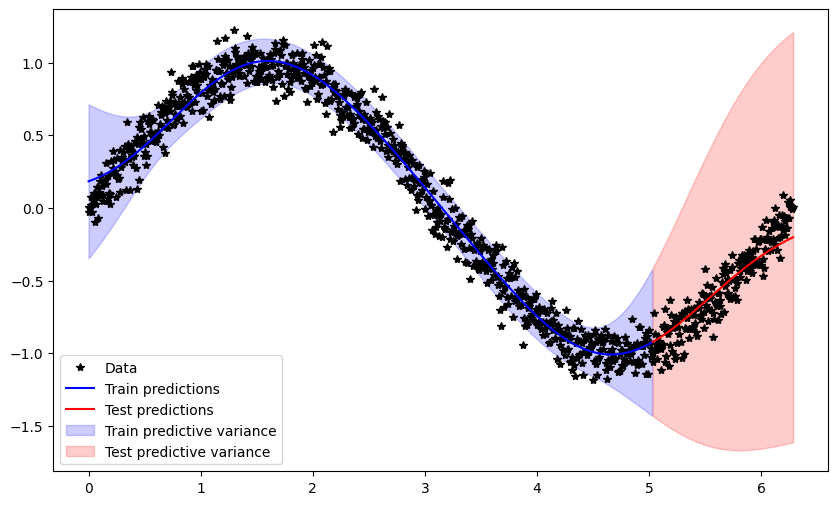

Test MAE: 0.2765113768966742


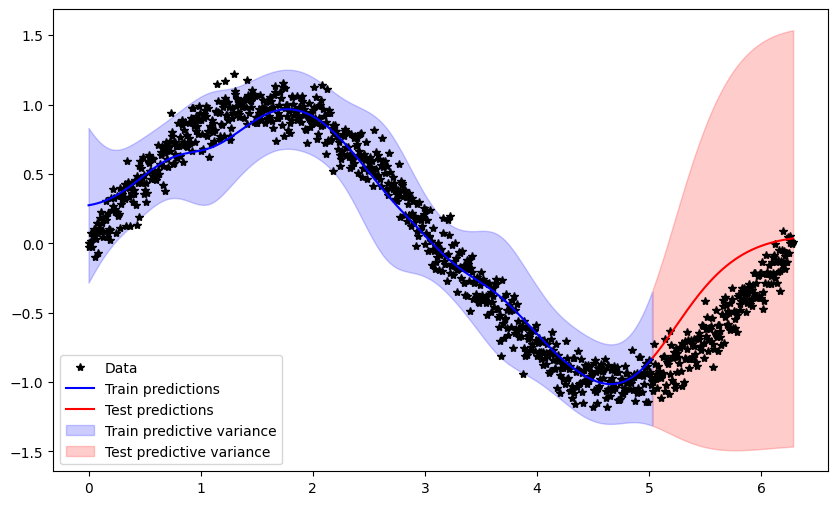

Test MAE: 0.25659964411809727


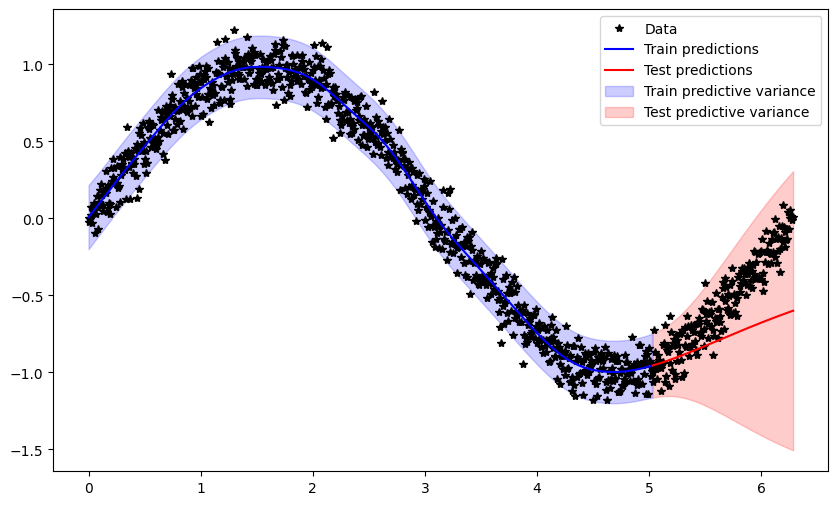

In [9]:
# def predict_and_plot(model, likelihood, train_loader, test_loader, exact: bool):
predict_and_plot(gpytorch_variational_gp,
                 gpytorch_variational_gp_likelihood,
                 DataLoader(train_dataset, batch_size=32, shuffle=False),
                 test_loader,
                 False)

predict_and_plot(botorch_variational_gp,
                 botorch_variational_gp.likelihood,
                 DataLoader(train_dataset, batch_size=32, shuffle=False),
                 test_loader,
                 False)

predict_and_plot(botorch_gp,
                 botorch_gp.likelihood,
                 DataLoader(train_dataset, batch_size=32, shuffle=False),
                 test_loader,
                 True)

### Other

In [10]:
from gp.variationalgp import MixedSingleTaskVariationalGP

# botorch_variational_gp = SingleTaskVariationalGP(train_x, train_y.unsqueeze(1), inducing_points=128)
# train_adj_ypre = train_y.unsqueeze(1)
train_adj_x = torch.cat((train_x, torch.zeros(train_x.size(0), 1, device='cuda')), dim=1)
# train_adj_y = torch.cat((train_adj_ypre, torch.zeros(train_adj_ypre.size(0), 1, device='cuda')), dim=1)
train_adj_y = train_y.unsqueeze(1)

test_adj_x = torch.cat((test_x, torch.zeros(test_x.size(0), 1, device='cuda')), dim=1)
test_adj_y = test_y.unsqueeze(1)
# test_adj_ypre = test_y.unsqueeze(1)
# test_adj_y = torch.cat((test_adj_ypre, torch.zeros(test_adj_ypre.size(0), 1, device='cuda')), dim=1)

print(train_y.shape)
print(train_adj_x.shape)
print(train_adj_y.shape)

train_adj_dataset = TensorDataset(train_adj_x, train_y)
test_adj_dataset = TensorDataset(test_adj_x, test_y)

torch.Size([800])
torch.Size([800, 2])
torch.Size([800, 1])


In [11]:
"""
fit_variational_gp(botorch_variational_gp.model,
                   botorch_variational_gp.likelihood,
                   train_loader,
                   num_epochs=5)
"""
inducing_points = train_adj_x[:500, :]

mixed_gp = MixedSingleTaskVariationalGP(
    train_X=train_adj_x,
    train_Y=train_adj_y,
    cat_dims=[1],
    # num_outputs=1,
    # learn_inducing_points=False,
    # variational_distribution=CholeskyVariationalDistribution(num_inducing_points=64),
    # variational_strategy=VariationalStrategy,
    inducing_points=128  # inducing_points  # Or provide actual inducing points tensor
).to(device='cuda')

fit_variational_gp(mixed_gp.model,
                    mixed_gp.likelihood,
                    DataLoader(train_adj_dataset, batch_size=32, shuffle=True),
                    num_epochs=10)

check torch.Size([])


/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1331], device='cuda:0', dtype=torch.float64), std = tensor([0.7174], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Test MAE: 0.0985391101445518


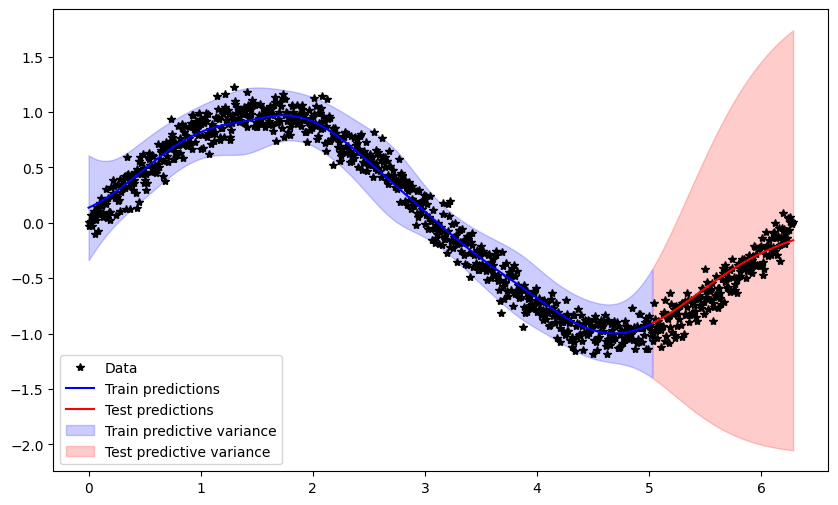

In [12]:
predict_and_plot(mixed_gp,
                 mixed_gp.likelihood,
                 DataLoader(train_adj_dataset, batch_size=32, shuffle=False),
                 DataLoader(test_adj_dataset, batch_size=32, shuffle=False),
                 False)

### Double check with MixedSingleTaskGP

Test MAE: 0.24713524793757455


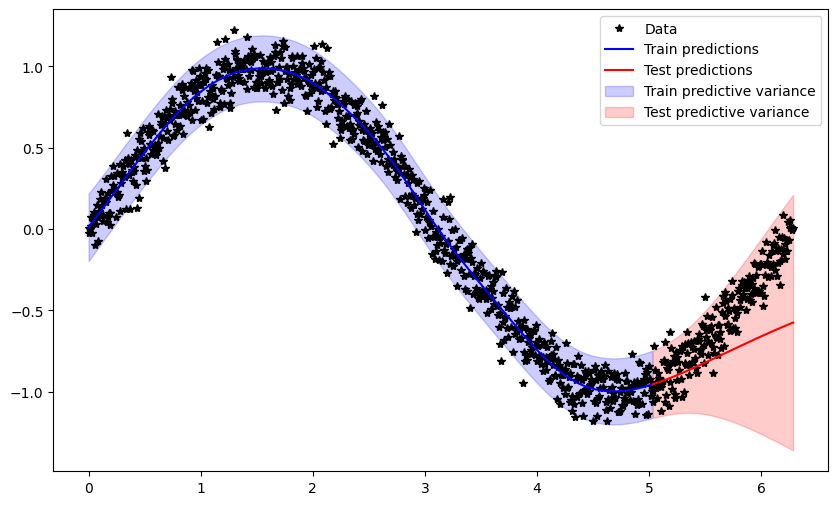

In [13]:
from botorch.models import MixedSingleTaskGP

mixed_gp2 = MixedSingleTaskGP(
    train_X=train_adj_x,
    train_Y=train_adj_y,
    cat_dims=[1]
).to(device='cuda')

fit_gpytorch_mll(ExactMarginalLogLikelihood(mixed_gp2.likelihood, mixed_gp2))

predict_and_plot(mixed_gp2,
                 mixed_gp2.likelihood,
                 DataLoader(train_adj_dataset, batch_size=32, shuffle=False),
                 DataLoader(test_adj_dataset, batch_size=32, shuffle=False),
                 True)

In [18]:
print(mixed_gp.posterior(test_adj_x[0:5]).mean)
print(mixed_gp2.posterior(test_adj_x[0:5]).mean)

tensor([[-0.9048],
        [-0.9017],
        [-0.8984],
        [-0.8952],
        [-0.8919]], device='cuda:0', dtype=torch.float64,
       grad_fn=<UnsqueezeBackward0>)
tensor([[-0.9551],
        [-0.9537],
        [-0.9522],
        [-0.9508],
        [-0.9494]], device='cuda:0', dtype=torch.float64,
       grad_fn=<UnsqueezeBackward0>)


In [15]:
var_gp = SingleTaskVariationalGP(
    train_X=train_adj_x,
    train_Y=train_adj_y,
    # num_outputs=1,
    # learn_inducing_points=True,
    # variational_distribution=CholeskyVariationalDistribution(num_inducing_points=64),
    # variational_strategy=VariationalStrategy,
    inducing_points=128  # Or provide actual inducing points tensor
).to(device='cuda')

fit_variational_gp(var_gp.model,
                   var_gp.likelihood,
                   DataLoader(train_adj_dataset, batch_size=32, shuffle=True))

/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1331], device='cuda:0', dtype=torch.float64), std = tensor([0.7174], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]